In [118]:
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az

In [54]:
df = pd.read_csv('population_housing_join.csv', index_col=0)
df

,city,state,year,births_census,censuspop_census,deaths_census,domesticmig_census,estimatesbase_census,internationalmig_census,naturalinc_census,netmig_census,npopchg_census,popestimate_census,residual_census,med_zhvi,med_zori
0,Abilene,TX,2010,541.0,165252.0,410.0,123.0,165252.0,89.0,131.0,212.0,338.0,165590.0,-5.0,101849.5,NaN
1,Abilene,TX,2011,2292.0,NaN,1501.0,68.0,NaN,206.0,791.0,274.0,1061.0,166651.0,-4.0,98293.5,NaN
2,Abilene,TX,2012,2359.0,NaN,1590.0,-456.0,NaN,529.0,769.0,73.0,832.0,167483.0,-10.0,100745.0,NaN
3,Abilene,TX,2013,2391.0,NaN,1691.0,-1064.0,NaN,373.0,700.0,-691.0,32.0,167515.0,23.0,101952.5,NaN
4,Abilene,TX,2014,2385.0,NaN,1597.0,-308.0,NaN,433.0,788.0,125.0,893.0,168408.0,-20.0,108733.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,Yuma,AZ,2016,3007.0,NaN,1511.0,-441.0,NaN,932.0,1496.0,491.0,1975.0,207162.0,-12.0,139248.0,NaN
4220,Yuma,AZ,2017,3006.0,NaN,1457.0,-40.0,NaN,581.0,1549.0,541.0,2082.0,209244.0,-8.0,147331.0,NaN
4221,Yuma,AZ,2018,2916.0,NaN,1594.0,374.0,NaN,314.0,1322.0,688.0,2001.0,211245.0,-9.0,155471.5,NaN
4222,Yuma,AZ,2019,3104.0,NaN,1659.0,777.0,NaN,720.0,1445.0,1497.0,2937.0,214182.0,-5.0,161821.0,NaN


In [56]:
order = 3

predictors = [
  'popestimate_census',
  'med_zhvi',
  'deaths_census'
]

output='med_zhvi'

We're doing modified autoregression because we're not estimating all of our predictors, we won't have a **prediction** past the next year unless we had a prediction for all of our predictors as well that we could feed back into the model. We'll either only be predicting for the next time slot or we'll have to come up with posterior models for each predictor to then feed back into the model. 

In [121]:
def generate_time_data(df, city, order, predictors, outputs):

  df = df.query(F"city== '{city}'")

  df_input = pd.DataFrame()
  years = []
  for year in range(df.year.min()+order, df.year.max()):

    df2 = df.query(F"year < {year} & year >= {year}-{order}")
    df2['step'] = [i for i in range(order)]
    df_pivot = df2.pivot(index='city', columns='step', values=predictors).reset_index()

    out = df.query(F"year == {year}").reset_index(drop=True)[outputs[0]].loc[0]
    out2 = df.query(F"year == {year}").reset_index(drop=True)[outputs[1]].loc[0]

    df_pivot['out'] = out
    df_pivot['out2'] = out2

    df_pivot = df_pivot.rename({'out':outputs[0],'out2':outputs[1]}, axis=1)
    df_input = pd.concat([df_input, df_pivot])
    years.append(year)

  df_input.insert(1, 'year',years)
  df_input = df_input.reset_index(drop=True)
  df_input.columns=[str(col[0]) + str(col[1]) for col in df_input.columns.values]
  return df_input

generate_time_data(df=df, city='Charlottesville',order=4, predictors = predictors, outputs=['med_zhvi', 'popestimate_census'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,city,year,popestimate_census0,popestimate_census1,popestimate_census2,popestimate_census3,med_zhvi0,med_zhvi1,med_zhvi2,med_zhvi3,deaths_census0,deaths_census1,deaths_census2,deaths_census3,med_zhvi,popestimate_census
0,Charlottesville,2014,201913.0,203683.0,205636.0,206887.0,269473.0,259929.0,259257.0,263915.5,423.0,1479.0,1477.0,1637.0,270048.0,209351.0
1,Charlottesville,2015,203683.0,205636.0,206887.0,209351.0,259929.0,259257.0,263915.5,270048.0,1479.0,1477.0,1637.0,1554.0,272673.5,211691.0
2,Charlottesville,2016,205636.0,206887.0,209351.0,211691.0,259257.0,263915.5,270048.0,272673.5,1477.0,1637.0,1554.0,1729.0,277095.0,213980.0
3,Charlottesville,2017,206887.0,209351.0,211691.0,213980.0,263915.5,270048.0,272673.5,277095.0,1637.0,1554.0,1729.0,1652.0,288738.0,216488.0
4,Charlottesville,2018,209351.0,211691.0,213980.0,216488.0,270048.0,272673.5,277095.0,288738.0,1554.0,1729.0,1652.0,1705.0,300367.5,217739.0
5,Charlottesville,2019,211691.0,213980.0,216488.0,217739.0,272673.5,277095.0,288738.0,300367.5,1729.0,1652.0,1705.0,1696.0,311332.0,219160.0


## Format Data for model input

In [122]:
cville = generate_time_data(df=df, city='Charlottesville',order=2, predictors=predictors, outputs=['med_zhvi','popestimate_census'])
cville

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,city,year,popestimate_census0,popestimate_census1,med_zhvi0,med_zhvi1,deaths_census0,deaths_census1,med_zhvi,popestimate_census
0,Charlottesville,2012,201913.0,203683.0,269473.0,259929.0,423.0,1479.0,259257.0,205636.0
1,Charlottesville,2013,203683.0,205636.0,259929.0,259257.0,1479.0,1477.0,263915.5,206887.0
2,Charlottesville,2014,205636.0,206887.0,259257.0,263915.5,1477.0,1637.0,270048.0,209351.0
3,Charlottesville,2015,206887.0,209351.0,263915.5,270048.0,1637.0,1554.0,272673.5,211691.0
4,Charlottesville,2016,209351.0,211691.0,270048.0,272673.5,1554.0,1729.0,277095.0,213980.0
5,Charlottesville,2017,211691.0,213980.0,272673.5,277095.0,1729.0,1652.0,288738.0,216488.0
6,Charlottesville,2018,213980.0,216488.0,277095.0,288738.0,1652.0,1705.0,300367.5,217739.0
7,Charlottesville,2019,216488.0,217739.0,288738.0,300367.5,1705.0,1696.0,311332.0,219160.0


## Generate Model for zvhi

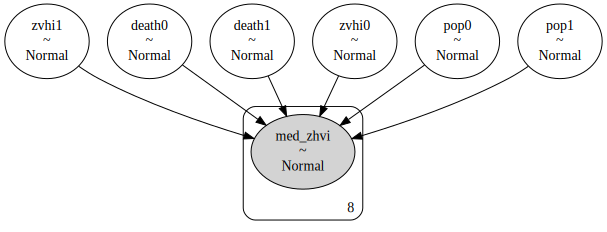

In [125]:
sig = 1000
with pm.Model() as model:

  pop0 = pm.Normal(name='pop0', mu=0, sigma=sig)
  pop1 = pm.Normal(name='pop1', mu=0, sigma=200)

  zhvi0 = pm.Normal(name='zvhi0', mu=0, sigma=sig)
  zhvi1 = pm.Normal(name='zvhi1', mu=0, sigma=sig)

  death0 = pm.Normal(name='death0', mu=0, sigma=sig)
  death1 = pm.Normal(name='death1', mu=0, sigma=sig)

  theta = (pop0*cville.popestimate_census0 + 
           pop1*cville.popestimate_census1 + 
           zhvi0*cville.med_zhvi0 + 
           zhvi1*cville.med_zhvi1 + 
           death0*cville.deaths_census0 +
           death1*cville.deaths_census1
  )

  med_zhvi = pm.Normal('med_zhvi', theta, sd=200, observed=cville.med_zhvi)

pm.model_to_graphviz(model)


In [117]:
with model:
    trace = pm.sample(1000)
    idata = az.from_pymc3(trace)
az.summary(idata, round_to=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [death1, death0, zvhi1, zvhi0, pop1, pop0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 426 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pop0,0.16,0.16,-0.16,0.45,0.01,0.01,470.35,687.98,1.00
pop1,-0.49,0.16,-0.77,-0.17,0.02,0.01,119.77,454.52,1.03
zvhi0,-0.03,0.10,-0.23,0.10,0.06,0.05,3.23,10.94,1.67
zvhi1,1.26,0.06,1.17,1.38,0.04,0.03,3.28,10.92,1.65
death0,5.10,1.28,2.66,6.75,0.75,0.63,3.13,10.96,1.73
death1,5.78,1.27,3.30,8.06,0.04,0.03,830.91,1140.06,1.01


## Generate Model for Population

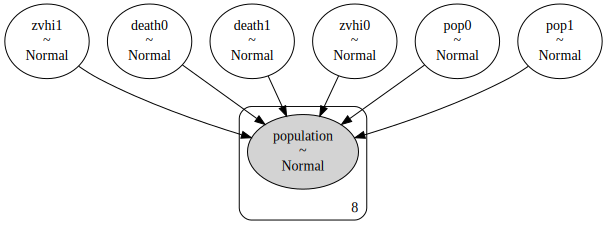

In [135]:
sig = 1000
with pm.Model() as model_pop:

  pop0 = pm.Normal(name='pop0', mu=0, sigma=sig)
  pop1 = pm.Normal(name='pop1', mu=0, sigma=200)

  zhvi0 = pm.Normal(name='zvhi0', mu=0, sigma=sig)
  zhvi1 = pm.Normal(name='zvhi1', mu=0, sigma=sig)

  death0 = pm.Normal(name='death0', mu=0, sigma=sig)
  death1 = pm.Normal(name='death1', mu=0, sigma=sig)

  theta = (pop0*cville.popestimate_census0 + 
           pop1*cville.popestimate_census1 + 
           zhvi0*cville.med_zhvi0 + 
           zhvi1*cville.med_zhvi1 + 
           death0*cville.deaths_census0 +
           death1*cville.deaths_census1
  )

  population = pm.Normal('population', theta, sd=200, observed=cville.popestimate_census)

pm.model_to_graphviz(model_pop)


In [137]:
with model_pop:
    trace = pm.sample(100)
    idata = az.from_pymc3(trace)
az.summary(idata, round_to=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [death1, death0, zvhi1, zvhi0, pop1, pop0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 203 seconds.
The acceptance probability does not match the target. It is 0.8806656315640121, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pop0,0.11,0.16,-0.19,0.39,0.04,0.03,18.24,47.12,1.08
pop1,0.92,0.16,0.59,1.17,0.04,0.03,19.49,27.34,1.08
zvhi0,0.02,0.04,-0.04,0.10,0.01,0.00,57.48,131.34,1.01
zvhi1,-0.06,0.03,-0.11,-0.01,0.00,0.00,42.24,121.28,1.00
death0,0.17,0.45,-0.67,1.01,0.06,0.05,51.18,149.90,1.01
death1,4.07,1.14,2.02,6.12,0.16,0.12,55.40,58.80,1.02
